# Final Project: Can we predict the performance of the contestants of RuPaul's Drag Race based on their home State?


## Set up Environment

In [64]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz

pd.set_option('display.max_rows', None)


## Read in the data sources
- We will read in three datasets 
1. *~/data/rpdr_contep.rda* - Contestant performance per episode from season 1 - 14
2. *~/data/rpdr_contestants.rda* - Contestant information like age and hometown
3. *~/data/lgbt_state_estimates.csv* - survey data on LGBT population per state 

In [4]:
# Load R data file of drag race contestants performance per episode
path ='/Users/navar135/Documents/UST/SEIS 631 Data Preparation and Analysis/dragrace/data/'
dat = pyreadr.read_r(path+'rpdr_contep.rda')   # returns a dictionary
df = list(dat.values())[0]
df.head()

,season,rank,missc,contestant,episode,outcome,eliminated,participant,minichalw,finale,penultimate
0,S01,1.0,0,BeBe Zahara Benet,1.0,SAFE,0,1,0,0.0,0.0
1,S01,2.0,1,Nina Flowers,1.0,WIN,0,1,0,0.0,0.0
2,S01,3.0,0,Rebecca Glasscock,1.0,LOW,0,1,0,0.0,0.0
3,S01,4.0,0,Shannel,1.0,SAFE,0,1,0,0.0,0.0
4,S01,5.0,0,Ongina,1.0,HIGH,0,1,0,0.0,0.0


In [5]:
# Load R data file of drag race contestants information
dat2= pyreadr.read_r(path+'rpdr_contestants.rda')   # returns a dictionary
df2 = list(dat2.values())[0]
df2.head()

,season,contestant,age,dob,hometown
0,S01,BeBe Zahara Benet,28.0,1981-03-20,"Minneapolis, Minnesota"
1,S01,Nina Flowers,34.0,1974-02-22,"Bayamón, Puerto Rico"
2,S01,Rebecca Glasscock,26.0,1983-05-25,"Fort Lauderdale, Florida"
3,S01,Shannel,26.0,1979-07-03,"Las Vegas, Nevada"
4,S01,Ongina,26.0,1982-01-06,"Los Angeles, California"


In [62]:
df2.to_csv(path+'rpdr_contestants.csv', index=False)

## Start Cleaning datasets

### Clean up hometown in drag race dataset for easy merging with population data 

- I will have to split the hometown column into two columns: city and state
- We will use the state column to join to our population data 

In [6]:
def split_hometown(hometown):
    if pd.isna(hometown):
        return pd.Series([None, None])

    # Special case: if multiple locations separated by "/", pick the U.S. one
    if "/" in hometown:
        parts = [p.strip() for p in hometown.split("/")]
        # pick the part that includes a U.S. state (assume contains a comma + long state name)
        for p in parts:
            if "," in p and len(p.split(",")[1].strip()) > 2:  # avoid UK, FR, etc.
                hometown = p.strip()

    # Now split normally
    if "," in hometown:
        city, state = [x.strip() for x in hometown.split(",", 1)]
    else:
        city, state = hometown.strip(), None

    return pd.Series([city, state])

df2[["city", "state"]] = df2["hometown"].apply(split_hometown)
df2[["city", "state"]] = df2[["city", "state"]].applymap(lambda x: x.lower() if isinstance(x, str) else x)

df2.head()

/var/folders/pc/vt9068d976n_zgv0df84cp_m0000gn/T/ipykernel_13972/771934551.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2[["city", "state"]] = df2[["city", "state"]].applymap(lambda x: x.lower() if isinstance(x, str) else x)


,season,contestant,age,dob,hometown,city,state
0,S01,BeBe Zahara Benet,28.0,1981-03-20,"Minneapolis, Minnesota",minneapolis,minnesota
1,S01,Nina Flowers,34.0,1974-02-22,"Bayamón, Puerto Rico",bayamón,puerto rico
2,S01,Rebecca Glasscock,26.0,1983-05-25,"Fort Lauderdale, Florida",fort lauderdale,florida
3,S01,Shannel,26.0,1979-07-03,"Las Vegas, Nevada",las vegas,nevada
4,S01,Ongina,26.0,1982-01-06,"Los Angeles, California",los angeles,california


In [26]:
df2.city.value_counts()

city
new york            21
los angeles         14
chicago             13
atlanta             10
las vegas            7
brooklyn             7
seattle              5
dallas               5
orlando              4
rochester            3
tampa                3
san francisco        3
minneapolis          3
boston               3
nashville            3
san juan             2
milwaukee            2
fort lauderdale      2
denver               2
kansas city          2
pittsburgh           2
johnson city         2
paris                2
springfield          2
austin               2
riverside            2
savannah             1
madison              1
harlem               1
the bronx            1
shreveport           1
redlands             1
indianapolis         1
gloucester           1
louisville           1
albuquerque          1
acworth              1
grand rapids         1
fayetteville         1
fresno               1
phoenix              1
scottsdale           1
conway               1
ramseu

In [7]:
df2.groupby("state").size().sort_values(ascending=False).head(10)

state
new york       34
california     28
florida        13
illinois       13
georgia        12
texas          10
puerto rico     9
nevada          7
washington      5
tennessee       5
dtype: int64

### Group episode level data and calculate each contestants number of challenge wins 
- The num of wins will be used as our main measure. It is defined as the proportion of episodes a single queen has won/ number of episodes in the season.
- We want to take the proportion rather than the raw counts because as the show has evolved more episodes have 


In [23]:
df.groupby('season')['episode'].nunique()

season
S01     7
S02    10
S03    13
S04    12
S05    12
S06    13
S07    13
S08    10
S09    12
S10    12
S11    14
S12    14
S13    16
S14    16
Name: episode, dtype: int64

In [6]:
df.outcome.value_counts()
# we are interested in the following outcomes:
# WIN/WINNER - win the main challenge


outcome
SAFE             471
BTM              304
HIGH             249
WIN              190
LOW              126
Guest             28
RTRN              21
LOSS               7
RUNNING            7
STAY               6
OUT                6
LOST1ST ROUND      6
LOST3RD ROUND      5
TOP2               5
TOP 4              4
Eliminated         3
LOST2ND ROUND      3
DISQ               1
SAFE+DEPT          1
WDR                1
Miss C             1
WIN+RTRN           1
SAVE               1
Winner             1
Runner-up          1
MISSCON            1
Name: count, dtype: int64

In [ ]:
# calculate the number of wins each queen had each season 
df['outcome'] = df['outcome'].str.strip().str.upper()

# Group by 'season' and 'contestant', count occurrences of 'WIN' or 'WINNER'
win_data = df.groupby(['season', 'contestant'])['outcome'].apply(
    lambda x: ((x == 'WIN') | (x == 'WINNER')).sum()).reset_index(name='num_wins').reset_index(drop=True)
    # Calculate the number of episodes per season
num_episodes = df.groupby('season')['episode'].nunique().reset_index(name='num_episodes')
# Merge the number of episodes into win_data
win_data = win_data.merge(num_episodes, on='season', how='left')
# Create a new column for the proportion of wins
win_data['win_rate'] = win_data['num_wins'] / win_data['num_episodes']
# Remove rows where all values are zero in the DataFrame
win_data = win_data.loc[~(win_data == 0).all(axis=1)]


,season,contestant,num_wins,num_episodes,win_rate
166,S13,Symone,6,16,0.375000
88,S07,Violet Chachki,5,13,0.384615
64,S06,Bianca Del Rio,5,13,0.384615
90,S08,Bob the Drag Queen,5,10,0.500000
44,S04,Sharon Needles,5,12,0.416667


In [22]:
# Sort the DataFrame by 'win_rate' in descending order
win_data = win_data.sort_values(by='win_rate', ascending=False)
win_data.head()

,season,contestant,num_wins,num_episodes,win_rate
90,S08,Bob the Drag Queen,5,10,0.500000
1,S01,BeBe Zahara Benet,3,7,0.428571
44,S04,Sharon Needles,5,12,0.416667
20,S02,Tyra Sanchez,4,10,0.400000
64,S06,Bianca Del Rio,5,13,0.384615


In [24]:
# Identify the winners for each season
winners = df.loc[(df['finale'] == 1) & (df['outcome'] == 'WIN') | (df['outcome'] == 'WINNER'), ['season', 'contestant']]
winners['season_winner'] = 1 
win_data = win_data.merge(winners, on=['season', 'contestant'], how='left')
win_data['season_winner']= win_data['season_winner'].fillna(0)
win_data[win_data['season_winner']==1]

,season,contestant,num_wins,num_episodes,win_rate,season_winner
0,S08,Bob the Drag Queen,5,10,0.500000,1.0
1,S01,BeBe Zahara Benet,3,7,0.428571,1.0
2,S04,Sharon Needles,5,12,0.416667,1.0
3,S02,Tyra Sanchez,4,10,0.400000,1.0
4,S06,Bianca Del Rio,5,13,0.384615,1.0
5,S07,Violet Chachki,5,13,0.384615,1.0
6,S13,Symone,6,16,0.375000,1.0
8,S10,Aquaria,4,12,0.333333,1.0
9,S03,Raja,4,13,0.307692,1.0
14,S12,Jaida Essence Hall,4,14,0.285714,1.0


### Clean up population information and create a binary column to group our queens into two groups
- Target column : High queer population density state vs low queer population density state
- This dataset has some drawbacks mainly it uses MSA as its geographical estimate so we wont have a one to one mapping. I have used my previous knowledge using fuzzy matching and some AI help to fuzzy match the msa to the hometowns of the queens. 
- We have 9 queens from Puerto Rico and one queen from Canada. I remove these queens to avoid issues with the analysis

In [37]:
pop_city_estimates = pd.read_csv(path+'lgbt_metro_estimates.csv')
pop_city_estimates.head()
# Standardize column names and string values to lowercase
pop_city_estimates.columns = pop_city_estimates.columns.str.lower()

pop_city_estimates = pop_city_estimates.applymap(lambda x: x.lower() if isinstance(x, str) else x)
pop_city_estimates.head()
pop_city_estimates['city'] = pop_city_estimates['msa'].str.split(r'[-/()]').str[0].str.strip()
pop_city_estimates['city'].value_counts(dropna=False)
pop_state_estimates =pop_city_estimates.copy()

/var/folders/pc/vt9068d976n_zgv0df84cp_m0000gn/T/ipykernel_13972/1086394921.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pop_city_estimates = pop_city_estimates.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [31]:
# pop_state_estimates = pd.read_csv(path+'lgbt_state_estimates.csv')
# pop_state_estimates.head(20)

In [33]:
display(pop_state_estimates.info())
pop_state_estimates.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   state         55 non-null     object
 1   msa           55 non-null     object
 2   % lgbt        55 non-null     object
 3   # lgbt total  55 non-null     int64 
 4   range low     55 non-null     int64 
 5   range high    55 non-null     int64 
 6   city          55 non-null     object
dtypes: int64(3), object(4)
memory usage: 3.1+ KB


None

,# lgbt total,range low,range high
count,55.000000,55.000000,55.000000
mean,112072.727273,103381.818182,121636.363636
std,118747.296974,114452.560269,123097.577019
min,23000.000000,20000.000000,27000.000000
25%,43000.000000,37500.000000,49500.000000
50%,74000.000000,66000.000000,83000.000000
75%,132000.000000,120500.000000,144000.000000
max,706000.000000,681000.000000,733000.000000


In [42]:
# # Standardize column names and string values to lowercase
# pop_state_estimates.columns = pop_state_estimates.columns.str.lower()

# pop_state_estimates = pop_state_estimates.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# pop_state_estimates.head()

# Rename the '% LGBT' column to 'percent_lgbt'
pop_state_estimates.rename(columns={"% lgbt": 'percent_lgbt'}, inplace=True)
# # Remove the '%' sign and convert the column to float
pop_state_estimates['percent_lgbt'] = pop_state_estimates['percent_lgbt'].str.replace('%', '').astype(float)


- Let's create a plot of how lgbt population differs across all states
- We will use this visual to decide our cutoff for our boolean of queer vs not queer state

<Axes: xlabel='percent_lgbt', ylabel='Count'>

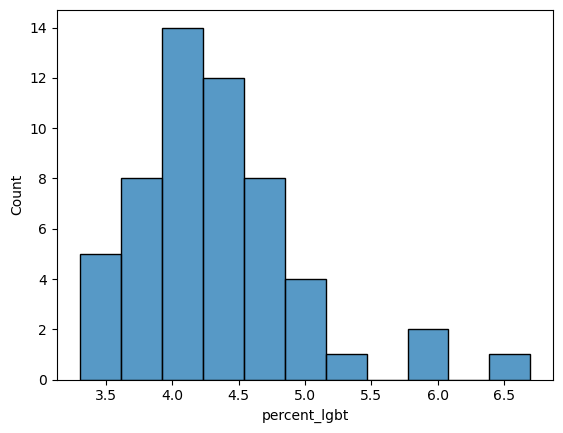

In [44]:
# sns.histplot(data=pop_state_estimates, x='lgbt_population_density')
sns.histplot(data=pop_state_estimates, x='percent_lgbt')

In [45]:
# pop_state_estimates['lgbt_population_density'].describe()
pop_state_estimates['percent_lgbt'].describe()

count    55.000000
mean      4.349091
std       0.645748
min       3.300000
25%       4.000000
50%       4.300000
75%       4.600000
max       6.700000
Name: percent_lgbt, dtype: float64

In [52]:
pop_state_estimates[pop_state_estimates['percent_lgbt']>4.35]['city']

1             tucson
2        los angeles
4         sacramento
5          san diego
6      san francisco
8             denver
9           hartford
10        washington
11             miami
13           orlando
14             tampa
15           atlanta
17      indianapolis
19       new orleans
21         worcester
22            boston
28         las vegas
29       albuquerque
33          new york
37          columbus
43          portland
44        providence
46            austin
49       san antonio
50    salt lake city
53           seattle
Name: city, dtype: object

- We will use 4.5% LGBT population density as our cutoff since this is higher than the mean and median
- Any state with less than 4.5% will be marked as 'low queer density' and any state above this cutoff will be marked as 'high queer density'
- There is no information for LGBT population in U.S territories so these will be marked as 'low queer density'

In [53]:
# create new boolean column for high queer density
# pop_state_estimates['high_queer_density'] = np.where(pop_state_estimates['lgbt_population_density'] > 4.5, 1, 0)
# pop_state_estimates.high_queer_density.value_counts(dropna=False)
pop_state_estimates['high_queer_density'] = np.where(pop_state_estimates['percent_lgbt'] >= 4.5, 1, 0)
pop_state_estimates.high_queer_density.value_counts(dropna=False)

high_queer_density
0    33
1    22
Name: count, dtype: int64

## Join our datasets
1. Join the dataset of all the contestants and their hometowns to the dataset of the performance of each queen per episode. This will be our main dataset.
2. Join the population information with our target column to the main dataset.

In [85]:

msa_list = pop_state_estimates["msa"].astype(str).tolist()

# ---------------------------------------------------------
# 1. Curated override dictionary for special cases
# ---------------------------------------------------------
override_map = {

    # ---------------------------
    # NEW YORK CITY REGION
    # ---------------------------
    "brooklyn": "new york (ny-nj-pa)",
    "manhattan": "new york (ny-nj-pa)",
    "queens": "new york (ny-nj-pa)",
    "bronx": "new york (ny-nj-pa)",
    "staten island": "new york (ny-nj-pa)",
    "harlem": "new york (ny-nj-pa)",
    "washington heights": "new york (ny-nj-pa)",
    "ridgewood": "new york (ny-nj-pa)",
    "flushing": "new york (ny-nj-pa)",
    "astoria": "new york (ny-nj-pa)",
    "elmwood park": "new york (ny-nj-pa)",
    "jersey city": "new york (ny-nj-pa)",
    "newark": "new york (ny-nj-pa)",
    "hoboken": "new york (ny-nj-pa)",
    "yonkers": "new york (ny-nj-pa)",
    "paterson": "new york (ny-nj-pa)",
    "clifton": "new york (ny-nj-pa)",

    # ---------------------------
    # LOS ANGELES METRO AREA
    # ---------------------------
    "west hollywood": "los angeles",
    "hollywood": "los angeles",
    "north hollywood": "los angeles",
    "van nuys": "los angeles",
    "reseda": "los angeles",
    "whittier": "los angeles",
    "long beach": "los angeles",
    "glendale": "los angeles",
    "pasadena": "los angeles",
    "granada hills": "los angeles",
    "azusa": "los angeles",

    # ---------------------------
    # SAN FRANCISCO / BAY AREA + SILICON VALLEY
    # ---------------------------
    "oakland": "san francisco/bay area",
    "berkeley": "san francisco/bay area",
    "richmond": "san francisco/bay area",
    "fremont": "san francisco/bay area",
    # silicon valley
    "san jose": "san jose-sunnyvale-santa clara",
    "santa clara": "san jose-sunnyvale-santa clara",

    # ---------------------------
    # SACRAMENTO REGION
    # ---------------------------
    "magalia": "sacramento",

    # ---------------------------
    # MIAMI METRO AREA
    # ---------------------------
    "fort lauderdale": "miami",
    "hollywood fl": "miami",
    "hollywood, florida": "miami",
    "west palm beach": "miami",

    # ---------------------------
    # CHICAGO METRO AREA
    # ---------------------------
    "oak park": "chicago (il-in-wi)",
    "evanston": "chicago (il-in-wi)",

    # ---------------------------
    # PHILADELPHIA REGION
    # ---------------------------
    "cherry hill": "philadelphia (pa-nj-de-md)",
    "camden": "philadelphia (pa-nj-de-md)",
    "bethlehem": "philadelphia (pa-nj-de-md)",

    # ---------------------------
    # TEXAS METROS
    # ---------------------------
    # Dallas–Fort Worth
    "arlington tx": "dallas-fort worth-arlington",
    "grand prairie": "dallas-fort worth-arlington",
    "plano": "dallas-fort worth-arlington",
    "fort worth": "dallas-fort worth-arlington",

    # Houston
    "spring": "houston",
    "katy": "houston",

    # ---------------------------
    # MICHIGAN / OHIO / MIDWEST
    # ---------------------------
    "akron": "cleveland",  # extremely close metro integration

    # ---------------------------
    # MASSACHUSETTS
    # ---------------------------
    "cambridge": "boston (ma-nh)"
}


# Normalize keys
override_map = {k.lower(): v for k, v in override_map.items()}


# ---------------------------------------------------------
# Main matching function
# ---------------------------------------------------------
def map_city_to_msa(city):
    if pd.isna(city):
        return None

    city_clean = city.strip().lower()
    if not city_clean:
        return None

    # ---- Step 1: Override dictionary ----
    for key in override_map:
        if key in city_clean:
            return override_map[key]

    # ---- Step 2: Exact match substring ----
    exact = [msa for msa in msa_list if city_clean in msa.lower()]
    if len(exact) == 1:
        return exact[0]
    elif len(exact) > 1:
        best, score, _ = process.extractOne(city_clean, exact, scorer=fuzz.WRatio)
        return best

    # ---- Step 3: Fuzzy match but only within same state ----
    state_clean = df2.loc[df2["city"].str.lower() == city_clean, "state"].values
    if len(state_clean) > 0:
        state_clean = state_clean[0].lower()
        state_metros = [m for m, s in zip(pop_state_estimates["msa"], pop_state_estimates["state"]) if str(s).lower() == state_clean]
    else:
        state_metros = msa_list  # fallback

    result = process.extractOne(city_clean, state_metros, scorer=fuzz.WRatio, score_cutoff=70)
    if result is None:
        return None

    best, _, _ = result
    return best


# Apply mapping
df2["msa"] = df2["city"].apply(map_city_to_msa)


In [86]:
df2['msa'].value_counts(dropna=False)

msa
None                                41
new york (ny-nj-pa)                 32
los angeles                         17
chicago (il-in-wi)                  13
atlanta                             10
las vegas                            7
dallas-fort worth-arlington          5
seattle-tacoma-bellevue              5
orlando                              4
tampa-st. petersburg-clearwater      4
minneapolis-st. paul (mn-wi)         3
nashville                            3
san francisco/bay area               3
rochester                            3
boston (ma-nh)                       3
milwaukee-waukesha-west allis        2
houston                              2
philadelphia (pa-nj-de-md)           2
denver                               2
kansas city (mo-ks)                  2
austin-round rock                    2
miami                                2
riverside-san bernardino-ontario     2
pittsburgh                           2
phoenix-mesa-scottsdale              2
cleveland            

In [81]:
df2[df2['msa'].isna()][['contestant', 'city', 'state']].sort_values(by='state')

,contestant,city,state
179,Maddy Morphosis,fayetteville,arkansas
157,Symone,conway,arkansas
175,DeJa Skye,fresno,california
16,Morgan McMichaels,mira loma,california
27,Delta Work,norwalk,california
91,Naomi Smalls,redlands,california
37,Latrice Royale,south beach,florida
59,Serena Cha Cha,tallahassee,florida
54,Jade Jolie,gainesville,florida
153,Aiden Zhane,acworth,georgia


In [87]:
# Merge contestant data with episode outcomes
drag_race_data = win_data.merge(df2, how='left', on=['season','contestant'])
display(drag_race_data.head())
display(drag_race_data.shape)
drag_race_data.info()

,season,contestant,num_wins,num_episodes,win_rate,season_winner,age,dob,hometown,city,state,mapped_msa,msa
0,S08,Bob the Drag Queen,5,10,0.500000,1.0,29.0,1986-06-22,"Brooklyn, New York",brooklyn,new york,new york (ny-nj-pa),new york (ny-nj-pa)
1,S01,BeBe Zahara Benet,3,7,0.428571,1.0,28.0,1981-03-20,"Minneapolis, Minnesota",minneapolis,minnesota,minneapolis-st. paul (mn-wi),minneapolis-st. paul (mn-wi)
2,S04,Sharon Needles,5,12,0.416667,1.0,29.0,1981-11-28,"Pittsburgh, Pennsylvania",pittsburgh,pennsylvania,pittsburgh,pittsburgh
3,S02,Tyra Sanchez,4,10,0.400000,1.0,21.0,1988-04-22,"Orlando, Florida",orlando,florida,orlando,orlando
4,S06,Bianca Del Rio,5,13,0.384615,1.0,36.0,1975-06-27,"New Orleans, Louisiana",new orleans,louisiana,new orleans,new orleans


(184, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         184 non-null    object 
 1   contestant     184 non-null    object 
 2   num_wins       184 non-null    int64  
 3   num_episodes   184 non-null    int64  
 4   win_rate       184 non-null    float64
 5   season_winner  184 non-null    float64
 6   age            184 non-null    float64
 7   dob            183 non-null    object 
 8   hometown       184 non-null    object 
 9   city           184 non-null    object 
 10  state          184 non-null    object 
 11  mapped_msa     143 non-null    object 
 12  msa            143 non-null    object 
dtypes: float64(3), int64(2), object(8)
memory usage: 18.8+ KB


In [89]:
# # Merge with state-level queer population density data to contestant data
# drag_race_pop_data = drag_race_data.merge(pop_state_estimates[['state','lgbt_population_density','high_queer_density']], how='left', on='state')
# display(drag_race_pop_data.head())
# display(drag_race_pop_data.info())
# drag_race_pop_data.shape

drag_race_pop_data = drag_race_data.merge(pop_state_estimates[['msa','city','state','percent_lgbt','high_queer_density']], how='left', on='msa')
display(drag_race_pop_data.head())
display(drag_race_pop_data.info())
drag_race_pop_data.shape

,season,contestant,num_wins,num_episodes,win_rate,season_winner,age,dob,hometown,city_x,state_x,mapped_msa,msa,city_y,state_y,percent_lgbt,high_queer_density
0,S08,Bob the Drag Queen,5,10,0.500000,1.0,29.0,1986-06-22,"Brooklyn, New York",brooklyn,new york,new york (ny-nj-pa),new york (ny-nj-pa),new york,new york,4.5,1.0
1,S01,BeBe Zahara Benet,3,7,0.428571,1.0,28.0,1981-03-20,"Minneapolis, Minnesota",minneapolis,minnesota,minneapolis-st. paul (mn-wi),minneapolis-st. paul (mn-wi),minneapolis,minnesota,4.2,0.0
2,S04,Sharon Needles,5,12,0.416667,1.0,29.0,1981-11-28,"Pittsburgh, Pennsylvania",pittsburgh,pennsylvania,pittsburgh,pittsburgh,pittsburgh,pennsylvania,3.3,0.0
3,S02,Tyra Sanchez,4,10,0.400000,1.0,21.0,1988-04-22,"Orlando, Florida",orlando,florida,orlando,orlando,orlando,florida,5.0,1.0
4,S06,Bianca Del Rio,5,13,0.384615,1.0,36.0,1975-06-27,"New Orleans, Louisiana",new orleans,louisiana,new orleans,new orleans,new orleans,louisiana,4.7,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              184 non-null    object 
 1   contestant          184 non-null    object 
 2   num_wins            184 non-null    int64  
 3   num_episodes        184 non-null    int64  
 4   win_rate            184 non-null    float64
 5   season_winner       184 non-null    float64
 6   age                 184 non-null    float64
 7   dob                 183 non-null    object 
 8   hometown            184 non-null    object 
 9   city_x              184 non-null    object 
 10  state_x             184 non-null    object 
 11  mapped_msa          143 non-null    object 
 12  msa                 143 non-null    object 
 13  city_y              143 non-null    object 
 14  state_y             143 non-null    object 
 15  percent_lgbt        143 non-null    float64
 16  high_que

None

(184, 17)

In [91]:
#  Check why some rows have NaN for lgbt_population_density
display(drag_race_pop_data[drag_race_pop_data['high_queer_density'].isna()])

# All null are queens from very small towns or outside the U.S.
drag_race_pop_data[drag_race_pop_data['high_queer_density'].isna()] = 0

display(drag_race_pop_data[drag_race_pop_data['high_queer_density'].isna()])


,season,contestant,num_wins,num_episodes,win_rate,season_winner,age,dob,hometown,city_x,state_x,mapped_msa,msa,city_y,state_y,percent_lgbt,high_queer_density
6,S13,Symone,6,16,0.375000,1.0,25.0,1995-01-15,"Conway, Arkansas",conway,arkansas,None,None,NaN,NaN,NaN,NaN
22,S03,Manila Luzon,3,13,0.230769,0.0,28.0,1981-08-10,"Cottage Grove, Minnesota",cottage grove,minnesota,None,None,NaN,NaN,NaN,NaN
23,S11,Brooke Lynn Hytes,3,14,0.214286,0.0,32.0,1986-03-10,"Toronto, Ontario, Canada",toronto,"ontario, canada",None,None,NaN,NaN,NaN,NaN
24,S08,Naomi Smalls,2,10,0.200000,0.0,21.0,1993-09-08,"Redlands, California",redlands,california,None,None,NaN,NaN,NaN,NaN
32,S10,Eureka O'Hara,2,12,0.166667,0.0,27.0,1990-08-26,"Johnson City, Tennessee",johnson city,tennessee,None,None,NaN,NaN,NaN,NaN
34,S04,Latrice Royale,2,12,0.166667,0.0,39.0,1972-02-12,"South Beach, Florida",south beach,florida,None,None,NaN,NaN,NaN,NaN
39,S07,Max,2,13,0.153846,0.0,22.0,1992-06-24,"Hudson, Wisconsin",hudson,wisconsin,None,None,NaN,NaN,NaN,NaN
42,S03,Shangela,2,13,0.153846,0.0,29.0,1981-11-22,"Paris, Texas",paris,texas,None,None,NaN,NaN,NaN,NaN
44,S01,Nina Flowers,1,7,0.142857,0.0,34.0,1974-02-22,"Bayamón, Puerto Rico",bayamón,puerto rico,None,None,NaN,NaN,NaN,NaN
45,S11,Silky Nutmeg Ganache,2,14,0.142857,0.0,28.0,1990-12-30,"Moss Point, Mississippi",moss point,mississippi,None,None,NaN,NaN,NaN,NaN


,season,contestant,num_wins,num_episodes,win_rate,season_winner,age,dob,hometown,city_x,state_x,mapped_msa,msa,city_y,state_y,percent_lgbt,high_queer_density


In [92]:
drag_race_pop_data['queer_state'] = np.where(drag_race_pop_data['high_queer_density'] == 1, 'High Queer Density State', 'Low Queer Density State')

In [93]:
drag_race_pop_data.head()

,season,contestant,num_wins,num_episodes,win_rate,season_winner,age,dob,hometown,city_x,state_x,mapped_msa,msa,city_y,state_y,percent_lgbt,high_queer_density,queer_state
0,S08,Bob the Drag Queen,5,10,0.500000,1.0,29.0,1986-06-22,"Brooklyn, New York",brooklyn,new york,new york (ny-nj-pa),new york (ny-nj-pa),new york,new york,4.5,1.0,High Queer Density State
1,S01,BeBe Zahara Benet,3,7,0.428571,1.0,28.0,1981-03-20,"Minneapolis, Minnesota",minneapolis,minnesota,minneapolis-st. paul (mn-wi),minneapolis-st. paul (mn-wi),minneapolis,minnesota,4.2,0.0,Low Queer Density State
2,S04,Sharon Needles,5,12,0.416667,1.0,29.0,1981-11-28,"Pittsburgh, Pennsylvania",pittsburgh,pennsylvania,pittsburgh,pittsburgh,pittsburgh,pennsylvania,3.3,0.0,Low Queer Density State
3,S02,Tyra Sanchez,4,10,0.400000,1.0,21.0,1988-04-22,"Orlando, Florida",orlando,florida,orlando,orlando,orlando,florida,5.0,1.0,High Queer Density State
4,S06,Bianca Del Rio,5,13,0.384615,1.0,36.0,1975-06-27,"New Orleans, Louisiana",new orleans,louisiana,new orleans,new orleans,new orleans,louisiana,4.7,1.0,High Queer Density State


<Axes: xlabel='queer_state', ylabel='win_rate'>

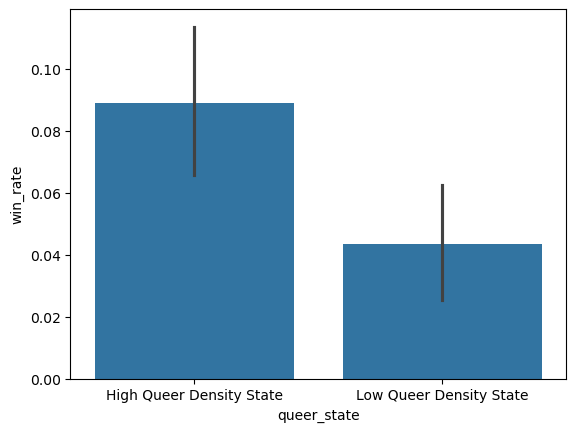

In [95]:
sns.barplot(data = drag_race_pop_data, x='queer_state',y='win_rate')

# Define test statistic

- Difference in the number of wins between queens from high queer density states vs low queer density state 

In [96]:
drag_race_pop_data.groupby('high_queer_density')['win_rate'].mean()

high_queer_density
0.0    0.043308
1.0    0.088872
Name: win_rate, dtype: float64

# Conduct permutation test

In [97]:
# observed statistic
def diff_num_wins(dat):
    high_queer_state= dat[dat['high_queer_density']==1]
    low_queer_state = dat[dat['high_queer_density']==0]
    return high_queer_state['win_rate'].mean() - low_queer_state['win_rate'].mean()

obs_diff = diff_num_wins(drag_race_pop_data)
print(f'Observed difference in number of wins: {obs_diff}')
# permutation test
num_sim = 20_000
replicates = np.empty(num_sim)

# copy dataset
for_sim = drag_race_pop_data.copy()

# permutation loop
for i in range(num_sim):
    shuffled_labels = np.random.permutation(for_sim['high_queer_density'])
    for_sim['high_queer_density'] = shuffled_labels
    
    diff = diff_num_wins(for_sim)
    replicates[i]=diff

# Compute p-value
p_value = np.mean(np.abs(replicates) >= abs(obs_diff))
print(f"P-value (two-sided): {p_value:.6f}")

Observed difference in number of wins: 0.04556394126706626
P-value (two-sided): 0.004250


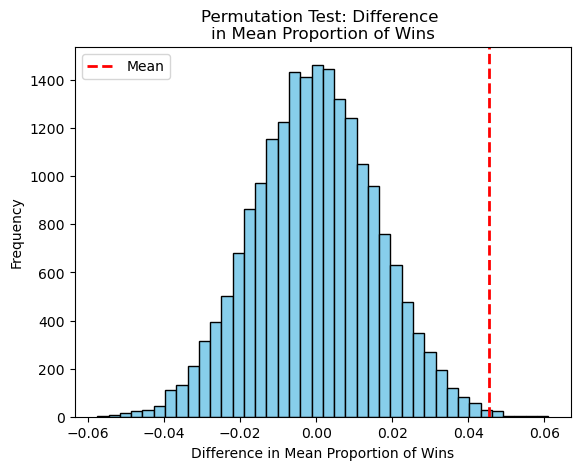

In [98]:
plt.hist(replicates, bins=40, edgecolor='black',color='skyblue')
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.title(f'Permutation Test: Difference \nin Mean Proportion of Wins')
plt.xlabel('Difference in Mean Proportion of Wins')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [84]:
drag_race_pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   season                   184 non-null    object 
 1   contestant               184 non-null    object 
 2   num_wins                 184 non-null    int64  
 3   season_winner            184 non-null    float64
 4   age                      184 non-null    float64
 5   dob                      183 non-null    object 
 6   hometown                 184 non-null    object 
 7   city                     184 non-null    object 
 8   state                    184 non-null    object 
 9   lgbt_population_density  175 non-null    float64
 10  high_queer_density       184 non-null    float64
 11  queer_state              184 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 17.4+ KB


# Look at age 



In [85]:
# add date of birth for missing row - taken from drag race wiki 
display(drag_race_pop_data[drag_race_pop_data.dob.isna()])
drag_race_pop_data.loc[drag_race_pop_data['contestant'] == 'June Jambalaya', 'dob'] = '1991-06-10'
display(drag_race_pop_data[drag_race_pop_data.dob.isna()])


,season,contestant,num_wins,season_winner,age,dob,hometown,city,state,lgbt_population_density,high_queer_density,queer_state
99,S14,June Jambalaya,0,0.0,29.0,None,"Los Angeles, California",los angeles,california,5.3,1.0,High Queer Density State


,season,contestant,num_wins,season_winner,age,dob,hometown,city,state,lgbt_population_density,high_queer_density,queer_state


In [93]:
drag_race_pop_data['older_queen'] = np.where(drag_race_pop_data['age'] > 35, 1, 0)

In [94]:
drag_race_pop_data.groupby('older_queen')['num_wins'].mean()

older_queen
0    1.056250
1    0.791667
Name: num_wins, dtype: float64

In [95]:
# observed statistic
def diff_num_wins_age(dat):
    older_queens= dat[dat['older_queen']==1]
    younger_queens = dat[dat['older_queen']==0]
    return older_queens['num_wins'].mean() - younger_queens['num_wins'].mean()

obs_diff = diff_num_wins_age(drag_race_pop_data)
print(f'Observed difference in number of wins: {obs_diff}')
# permutation test
num_sim = 20_000
replicates = np.empty(num_sim)

# copy dataset
for_sim = drag_race_pop_data.copy()

# permutation loop
for i in range(num_sim):
    shuffled_labels = np.random.permutation(for_sim['older_queen'])
    for_sim['older_queen'] = shuffled_labels
    
    diff = diff_num_wins_age(for_sim)
    replicates[i]=diff

# Compute p-value
p_value = np.mean(np.abs(replicates) >= abs(obs_diff))
print(f"P-value (two-sided): {p_value:.6f}")

Observed difference in number of wins: -0.2645833333333333
P-value (two-sided): 0.374700


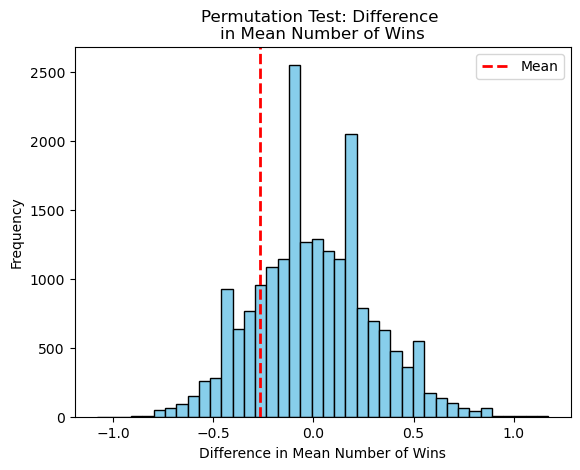

In [96]:
plt.hist(replicates, bins=40, edgecolor='black',color='skyblue')
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.title(f'Permutation Test: Difference \nin Mean Number of Wins')
plt.xlabel('Difference in Mean Number of Wins')
plt.ylabel('Frequency')
plt.legend()
plt.show()